In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import importlib
import subprocess

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions

import ATARI.utils.io.hdf5 as h5io

from copy import copy
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.PiTFAll import fnorm


In [2]:
%matplotlib widget

In [3]:
def plot_trans(exp_pw, T1):
    
    fig = figure()
    # plot(exp_pw.E, exp_pw.theo_trans, ms=1, color='g')
    # plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, 'r', alpha=0.2, lw=3)
    # plot(sammyOUT_bayes.pw.E, sammyOUT_bayes.pw.theo_trans_bayes, 'b-')
    plot(T1.E, T1.theo_trans, 'b')
    errorbar(exp_pw.E, exp_pw.exp, yerr=exp_pw.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    ylim([-.1, 1])
    return fig


def plot_trans_cap(trans, cap, T1=None,C1=None, plot_true=False):

    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)
    axes[0].errorbar(trans.E, trans.exp, yerr=trans.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    axes[1].errorbar(cap.E, cap.exp, yerr=cap.exp_unc, zorder=0, 
                                            fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')
    
    if C1 is not None and T1 is not None:
        axes[0].plot(T1.E, T1.theo_trans, 'b')
        axes[1].plot(C1.E, C1.theo_xs, 'b')
        if plot_true:
            axes[0].plot(trans.E, trans.true, 'g')
            axes[1].plot(cap.E, cap.true, 'g')
    else:
        axes[0].plot(trans.E, trans.true, 'g')
        axes[1].plot(cap.E, cap.true, 'g')
        

    axes[0].set_ylabel("T")
    axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$\sigma_{\gamma}$ (barns)')
    axes[1].set_ylim(bottom=5e-4)

    # legend()
    fig.supxlabel('Energy (eV)')
    fig.tight_layout()
    return fig


In [4]:
### Setup physics
Gg_DOF = 10
spin_groups = [ (3.0,1,0) ]
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= 0.658, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)

ac = 0.81271; M = 180.948030; m = 1; I = 3.5; i = 0.5; l_max = 1 
average_parameters = {'3.0':res_par_avg}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   



In [10]:
#%% pull estimates
importlib.reload(fnorm)

sammy_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'
shell = 'zsh'
template = "dop_1sg.inp"
reactions = ["elastic", "capture"]

case_file = "/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/data.hdf5"

energy_range = [75,125]
temperature = 300
target_thickness = 0.067166 

result_dict = {}
res_dict = {}
# for gn in ["Gnavg", "Gnmin"]:
for gn in ["Gnavg"]:
    for ithresh in ["1en2", "1en3", "1en4", "1en5"]:

        basepath = f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/{gn}_fits_{ithresh}"
        case = os.path.basename(basepath)
        
        fnorms_iE = []
        res_iE = []
        for iE in [25,50,75,100]:

            true_par_list = []
            est_par_list = []
            for isample in range(500):
                true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

                try:
                    csvfile = os.path.join(basepath, f"par_i{isample}_iE{iE}.csv")
                    par_df = pd.read_csv(csvfile)
                    est_par = par_df[["E", "Gg", "Gn1"]]
                    est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))
                    # est_par = est_par[abs(est_par.Gn1>1e-5)]

                    true_par_list.append(true_par)
                    est_par_list.append(est_par)
                except:
                    pass


            Rdict = fnorm.build_residual_matrix_dict(est_par_list, true_par_list,
                                    sammy_exe, shell,
                                    Ta_pair, 
                                    energy_range,
                                    temperature, 
                                    target_thickness,
                                    template, reactions, 
                                    print_bool=False)
            Fnorms = fnorm.calculate_fnorms(Rdict, reactions)
            fnorms_iE.append(Fnorms)
            res_iE.append(Rdict)

            print(f"Done with case {case}, iE {iE}")

        result_dict[case] = fnorms_iE
        res_dict[case] = res_iE


In [73]:
basepath = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/ref_fits"
true_par_list = []
est_par_list = []
for isample in range(500):
    true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

    try:
        csvfile = os.path.join(basepath, f"par_i{isample}.csv")
        par_df = pd.read_csv(csvfile)
        est_par = par_df[["E", "Gg", "Gn1"]]
        est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))
        # est_par = est_par[abs(est_par.Gn1>1e-5)]

        true_par_list.append(true_par)
        est_par_list.append(est_par)
    except:
        print(f"Failed {isample}")


Rdict = fnorm.build_residual_matrix_dict(est_par_list, true_par_list,
                        sammy_exe, shell,
                        Ta_pair, 
                        energy_range,
                        temperature, 
                        target_thickness,
                        template, reactions, 
                        print_bool=True)
Fnorms_reference = fnorm.calculate_fnorms(Rdict, reactions)


Completed Job: 1
Completed Job: 2
Completed Job: 3
Completed Job: 4
Completed Job: 5
Completed Job: 6
Completed Job: 7
Completed Job: 8
Completed Job: 9
Completed Job: 10
Completed Job: 11
Completed Job: 12
Completed Job: 13
Completed Job: 14
Completed Job: 15
Completed Job: 16
Completed Job: 17
Completed Job: 18
Completed Job: 19
Completed Job: 20
Completed Job: 21
Completed Job: 22
Completed Job: 23
Completed Job: 24
Completed Job: 25
Completed Job: 26
Completed Job: 27
Completed Job: 28
Completed Job: 29
Completed Job: 30
Completed Job: 31
Completed Job: 32
Completed Job: 33
Completed Job: 34
Completed Job: 35
Completed Job: 36
Completed Job: 37
Completed Job: 38
Completed Job: 39
Completed Job: 40
Completed Job: 41
Completed Job: 42
Completed Job: 43
Completed Job: 44
Completed Job: 45
Completed Job: 46
Completed Job: 47
Completed Job: 48
Completed Job: 49
Completed Job: 50
Completed Job: 51
Completed Job: 52
Completed Job: 53
Completed Job: 54
Completed Job: 55
Completed Job: 56
C

In [57]:

# count_dict = {}
# for gn in ["Gnavg", "Gnmin"]:
#     for ithresh in ["1en2", "1en3", "1en4", "1en5"]:

#         basepath = f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/{gn}_fits_{ithresh}"
        
#         counts = [0,0,0,0]
#         for i, iE in enumerate([25,50,75,100]):

#             true_par_list = []
#             est_par_list = []
#             for isample in range(500):
#                 true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

#                 try:
#                     csvfile = os.path.join(basepath, f"par_i{isample}_iE{iE}.csv")
#                     par_df = pd.read_csv(csvfile)
#                     est_par = par_df[["E", "Gg", "Gn1"]]
#                     est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))
#                     # est_par = est_par[abs(est_par.Gn1>1e-5)]

#                     true_par_list.append(true_par)
#                     est_par_list.append(est_par)
                    
#                     counts[i] += 1
#                 except:
#                     pass

#         case = os.path.basename(basepath)
#         count_dict[case] = counts


In [58]:
count_dict

{'Gnavg_fits_1en2': [500, 500, 500, 500],
 'Gnavg_fits_1en3': [500, 500, 500, 500],
 'Gnavg_fits_1en4': [500, 500, 500, 500],
 'Gnavg_fits_1en5': [500, 500, 500, 499],
 'Gnmin_fits_1en2': [500, 500, 500, 500],
 'Gnmin_fits_1en3': [500, 500, 500, 500],
 'Gnmin_fits_1en4': [500, 500, 500, 500],
 'Gnmin_fits_1en5': [500, 500, 500, 500]}

In [89]:
fnorms_iE = result_dict["Gnmin_fits_1en2"]
x = [25,50,75, 100]
print(x)
print([f["total"] for f in fnorms_iE])
print([f["capture"] for f in fnorms_iE])
print([f["all"] for f in fnorms_iE])

print([f["total"] + f["capture"]**2 for f in fnorms_iE])

[25, 50, 75, 100]
[61256.38075029605, 16415.775721117687, 14599.954533213135, 14085.770461773978]
[17879.444598157414, 15441.117224017233, 13757.482780536317, 13248.386300989914]
[63812.371228186006, 22536.765376865395, 20060.583362121964, 19337.23530089143]
[319735795.5193306, 238444516.90156275, 189282932.41128647, 175533825.35071898]


In [74]:
print(Fnorms_reference["total"]**2 + Fnorms_reference["capture"]**2)
# Fnorms_reference

2358979.5155590344


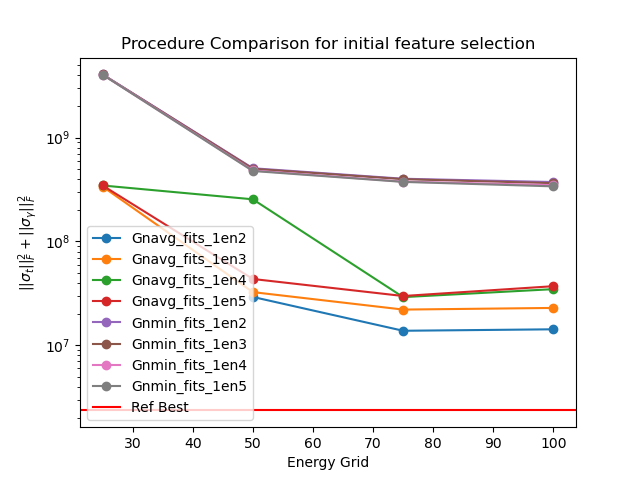

In [90]:
iE = [25,50,75,100]

figure()

for gn in ["Gnavg", "Gnmin"]:
    for ithresh in ["1en2", "1en3", "1en4", "1en5"]:
        label = f"{gn}_fits_{ithresh}"
        dat = result_dict[label]

        # for iE in [25,50,75,100]:
        metric_v_iE = [f["total"]**2 + f["capture"]**2 for f in dat]

        plot(iE, metric_v_iE, 'o-', label=label)# '_'.join(label.split("_")[0,2]) )

reference_metric = Fnorms_reference["total"]**2 + Fnorms_reference["capture"]**2 
axhline(reference_metric,  label="Ref Best", color='r')

xlabel("Energy Grid")
title("Procedure Comparison for initial feature selection")
ylabel(r"$||\sigma_t||_F^2 + ||\sigma_{\gamma}||_F^2$")
yscale('log')
legend()

In [91]:

# figure()

# for rxn in reactions:
#     plot(x, [f[rxn] for f in fnorms_iE], '.-', label=rxn)

# plot(x, [f["all"] for f in fnorms_iE], '.-', label="all rxn")

# xlabel('iE')
# ylabel(r'$||R||_{F}$')
# title("Fnorm 500 samples; sammy GD feature selection\n <Gn>, <Gg>, elim Gn<1e-5 meV")
# legend()

In [87]:

# iE = 100
# true_par_list = []
# est_par_list = []
# Gn_list = []
# for isample in range(500):
#     true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

#     try:
#         csvfile = os.path.join(basepath, f"par_i{isample}_iE{iE}.csv")
#         par_df = pd.read_csv(csvfile)
#         est_par = par_df[["E", "Gg", "Gn1"]]
#         est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))

#         true_par_list.append(true_par)
#         est_par_list.append(est_par)
#         Gn_list.extend(list(est_par.Gn1))
#     except:
#         pass

In [86]:
# Gn_list

In [30]:
# abs(np.sum(Rdict['capture'], axis=1))
np.argmax(abs(np.sum(Rdict['capture'], axis=1)))#.shape

2

### For interrogating a single case

In [72]:
# importlib.reload(fnorm)
iE = 25
isample = 3
ithresh = "1en4"
gn = "Gnavg"

dataset_titles = ["trans1", "cap1"]
datasets = []
for dt in dataset_titles:
    exp_pw, exp_cov = h5io.read_pw_exp(case_file, isample, title=dt)
    datasets.append(exp_pw)

trans = datasets[0]
cap = datasets[1]

# basepath = f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/{gn}_fits_{ithresh}"
basepath = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/ref_fits"


true_par = h5io.read_par(case_file, isample, 'true')  #for fine grid theoretical

csvfile = os.path.join(basepath, f"par_i{isample}_iE{iE}.csv")
par_df = pd.read_csv(csvfile)
est_par = par_df[["E", "Gg", "Gn1"]]
est_par = sammy_functions.fill_sammy_ladder(est_par, Ta_pair, J_ID=np.ones(len(est_par)))

# true_par = true_par_list[isample]
# est_par = est_par_list[isample]

est_df, true_df = fnorm.get_rxns(true_par, est_par,
                            sammy_exe, shell,
                            Ta_pair, 
                            energy_range,
                            temperature, 
                            target_thickness,
                            template, reactions)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/RM_allexp/sammy/ref_fits/par_i3_iE25.csv'

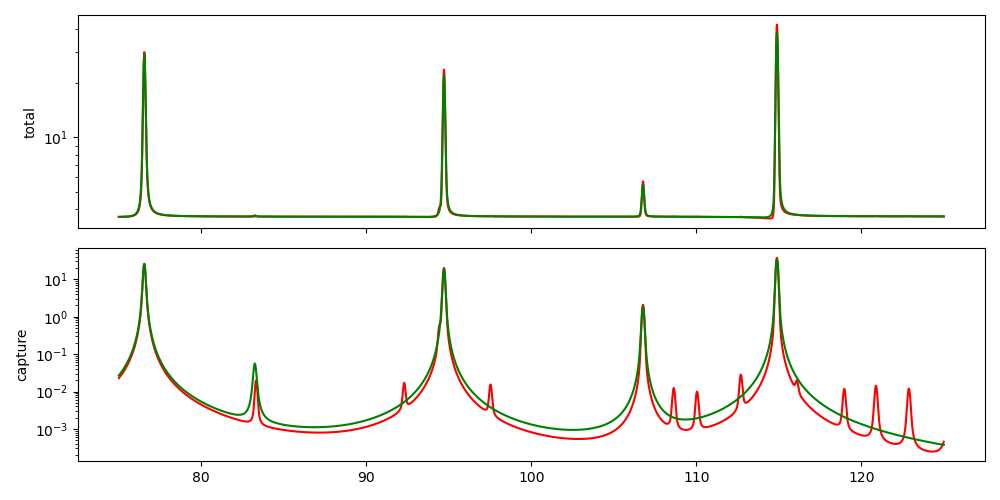

In [71]:

fig, axes = subplots(2,1, figsize=(10,5), sharex=True)

for i in range(2):
    axes[i].plot(est_df.E, est_df[reactions[i]], 'r')
    axes[i].plot(true_df.E, true_df[reactions[i]], 'g')

    axes[i].set_yscale('log')
    axes[i].set_ylabel(reactions[i])

# axes[1].plot(cap.E, cap.exp,'k.')

fig.tight_layout()

In [ ]:
# import imageio


# def make_fitgif(isample, iE):

#     with open(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/ifinal_nE{iE}.txt", 'r') as f:
#         lines = f.readlines()
#     for line in lines:
#         if line.startswith(f"{isample} "):
#             ifinals = line.split()
    
#     for istep in [1,2,3,4]:
#         folder = f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/sample_{isample}_iE{iE}_step{istep}"
#         for i in range(1,int(ifinals[istep])):
            
#             C1 = sammy_functions.readlst(os.path.join(folder,f"results/cap1_step{i}.lst"))
#             T1 = sammy_functions.readlst(os.path.join(folder,f"results/trans1_step{i}.lst"))
#             fig = plot_trans_cap(exp_pw, cap_pw, T1=T1, C1=C1)
#             fig.suptitle(f"Step: {istep}")

#             fig.savefig(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png")
#             close()
        
#     images = []
#     for istep in [1,2,3,4]:
#         for i in range(1,int(ifinals[istep])): #range(start_job,end_job):
#             images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png"))
#     imageio.mimsave(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/sample{isample}_iE{iE}.gif", images)

In [ ]:
# for istep in [1,2,3,4]:
#     fig = makefig()
#     fig.savefig(f"somewhere/sample{istep}.png")
#     close()
    
# images = []
# for istep in [1,2,3,4]:
#     images.append(imageio.imread(f"somewhere/sample{istep}.png"))
# imageio.mimsave(f"somewhere/my.gif", images)


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_35036/1029206176.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"/Users/noahwalton/Documents/GitHub/ATARI/Fitting/noah_dev/fit_w_sammy/SAMMY_runDIRs/figures/sample{isample}_iE{iE}_step{istep}_{i}.png"))


In [19]:
# os.system(os.path.join(sammyRTO.sammy_runDIR, 'run.zsh'))
